# Time series plots

This notebook plots a number of time series derived from the prospectivity models, including average prospectivity and total prospective area through time.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

In [1]:
config_file = "notebook_parameters_default.yml"

In [2]:
from lib.load_params import get_params

params = get_params(config_file, notebook="08")

# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = params["use_extracted_data"]

# Output directory
output_dir = params["output_dir"]

## Notebook setup

Imports, definitions, etc.

### Imports

In [3]:
import glob
import os
import warnings
from itertools import cycle

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    from gplately import (
        Raster,
        EARTH_RADIUS as earth_radius,
    )
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

from lib.check_files import check_prepared_data

warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", UserWarning)

### Input and output files

In [4]:
if use_extracted_data:
    data_dir = params["extracted_data_dir"]
else:
    data_dir = check_prepared_data("prepared_data", verbose=True)

deposits_filename = os.path.join(
    data_dir,
    "training_data_global.csv",
)

lh_dir = os.path.join(output_dir, "global", "preservation_likelihood_grids")
erodep_dist_filename = os.path.join(output_dir, "global", "erodep_dist.joblib")
erosion_dir = os.path.join(output_dir, "erosion_grids")

output_dir = os.path.join(
    output_dir,
    "global",
    "PU",
)

figures_dir = os.path.join(output_dir, "time_series")
os.makedirs(figures_dir, exist_ok=True)

deposits = pd.read_csv(deposits_filename)
deposits = deposits[deposits["label"] == "positive"]

### Functions

In [5]:
lh_transform = make_pipeline(
    FunctionTransformer(np.log, np.exp),
    MinMaxScaler(),
)
all_lh = []
lh_filenames = glob.glob(os.path.join(lh_dir, "preservation_likelihood_grid_*Ma.nc"))
for lh_filename in lh_filenames:
    lh = Raster(lh_filename).data
    if isinstance(lh, np.ma.MaskedArray):
        lh = lh.data
    lh = np.ravel(lh)
    lh = lh[~np.isnan(lh)]
    lh = lh[lh != 0.0]
    all_lh.append(lh)
all_lh = np.reshape(np.concatenate(all_lh), (-1, 1))
lh_transform.fit(all_lh)
del all_lh

erodep_dist = joblib.load(erodep_dist_filename)


def transform_lh(a, transform):
    if isinstance(a, np.ma.MaskedArray):
        a = a.data
    a = np.array(a)
    a[a == 0.0] = np.nan
    inds = np.where(~np.isnan(a))
    a_valid = np.reshape(a[inds], (-1, 1))
    a_transformed = np.ravel(transform.transform(a_valid))
    a[inds] = a_transformed
    return a

## Extract statistics

The following cells extract the relevant information from the models.

### Probability

In [6]:
qs = np.arange(0.0, 1.1, 0.1)
regions = (
    "Global",
    "North America",
    "South America",
    "Southeast Asia",
    "Tethys",
)
quantiles = {
    region: {}
    for region in regions
}
quantiles_areas = {
    region: {}
    for region in regions
}
quantiles_areas_normalised = {
    region: {}
    for region in regions
}
quantiles_preservation = {
    region: {}
    for region in regions
}
quantiles_areas_preservation = {
    region: {}
    for region in regions
}
quantiles_areas_normalised_preservation = {
    region: {}
    for region in regions
}

for region in regions:
    if region == "Global":
        input_filename = os.path.join(
            output_dir,
            "grid_probabilities.csv",
        )
        probs = pd.read_csv(input_filename)
    else:
        r = "_".join(region.lower().split())
        input_filename = os.path.join(
            output_dir,
            f"grid_probabilities_{r}.csv",
        )
        probs = pd.read_csv(input_filename)
        probs = probs[probs["region"] == region]

    erosion = probs["erosion (m)"]
    lh_unscaled = erodep_dist.pdf(erosion)
    lh_scaled = transform_lh(lh_unscaled, lh_transform)
    probs = pd.DataFrame(probs)
    probs["likelihood"] = np.array(lh_scaled)
    probs = probs.dropna()
    probs["probability_likelihood"] = probs["probability"] * probs["likelihood"]

    lon_array = np.unique(probs["lon"])
    np.sort(lon_array)
    dx = np.quantile(np.gradient(lon_array), 0.5)
    lat_array = np.unique(probs["lat"])
    np.sort(lat_array)
    dy = np.quantile(np.gradient(lat_array), 0.5)

    cell_height = np.deg2rad(dy) * earth_radius
    cell_widths = (
        np.deg2rad(dx) * earth_radius  # width at equator
        * np.cos(np.deg2rad(probs["lat"]))
    )
    cell_areas = cell_widths * cell_height
    probs["cell_area"] = cell_areas

    times = probs["age (Ma)"].unique()
    np.sort(times)
    quantiles[region]["mean"] = []
    quantiles_preservation[region]["mean"] = []
    for q in qs:
        quantiles[region][q] = []
        quantiles_areas[region][q] = []
        quantiles_areas_normalised[region][q] = []
        quantiles_preservation[region][q] = []
        quantiles_areas_preservation[region][q] = []
        quantiles_areas_normalised_preservation[region][q] = []
    for time in times:
        probs_time = probs[probs["age (Ma)"] == time]
        quantiles[region]["mean"].append(probs_time["probability"].mean())
        quantiles_preservation[region]["mean"].append(probs_time["probability_likelihood"].mean())
        for q in qs:
            quantiles[region][q].append(probs_time["probability"].quantile(q))
            quantiles_preservation[region][q].append(probs_time["probability_likelihood"].quantile(q))

            area_total = probs_time["cell_area"].sum()

            probs_q = probs_time[probs_time["probability"] >= q]
            area_q = probs_q["cell_area"].sum()
            quantiles_areas[region][q].append(area_q)
            quantiles_areas_normalised[region][q].append(area_q / area_total)

            probs_q_preservation = probs_time[probs_time["probability_likelihood"] >= q]
            area_q_preservation = probs_q_preservation["cell_area"].sum()
            quantiles_areas_preservation[region][q].append(area_q_preservation)
            quantiles_areas_normalised_preservation[region][q].append(area_q_preservation / area_total)

    quantiles[region]["mean"] = pd.Series(quantiles[region]["mean"], index=times)
    quantiles_preservation[region]["mean"] = pd.Series(quantiles_preservation[region]["mean"], index=times)
    for q in qs:
        quantiles[region][q] = pd.Series(quantiles[region][q], index=times)
        quantiles_areas[region][q] = pd.Series(quantiles_areas[region][q], index=times)
        quantiles_areas_normalised[region][q] = pd.Series(quantiles_areas_normalised[region][q], index=times)

        quantiles_preservation[region][q] = pd.Series(quantiles_preservation[region][q], index=times)
        quantiles_areas_preservation[region][q] = pd.Series(quantiles_areas_preservation[region][q], index=times)
        quantiles_areas_normalised_preservation[region][q] = pd.Series(quantiles_areas_normalised_preservation[region][q], index=times)

In [7]:
quantiles_areas_global = {
    region: {}
    for region in regions
}
quantiles_areas_normalised_global = {
    region: {}
    for region in regions
}
quantiles_areas_global_preservation = {
    region: {}
    for region in regions
}
quantiles_areas_normalised_global_preservation = {
    region: {}
    for region in regions
}

input_filename = os.path.join(
    output_dir,
    "grid_probabilities.csv",
)
probs = pd.read_csv(input_filename)
lon_array = np.unique(probs["lon"])
np.sort(lon_array)
dx = np.quantile(np.gradient(lon_array), 0.5)
lat_array = np.unique(probs["lat"])
np.sort(lat_array)
dy = np.quantile(np.gradient(lat_array), 0.5)

cell_height = np.deg2rad(dy) * earth_radius
cell_widths = (
    np.deg2rad(dx) * earth_radius  # width at equator
    * np.cos(np.deg2rad(probs["lat"]))
)
cell_areas = cell_widths * cell_height
probs["cell_area"] = cell_areas

erosion = probs["erosion (m)"]
lh_unscaled = erodep_dist.pdf(erosion)
lh_scaled = transform_lh(lh_unscaled, lh_transform)
probs = pd.DataFrame(probs)
probs["likelihood"] = np.array(lh_scaled)
probs = probs.dropna()
probs["probability_likelihood"] = probs["probability"] * probs["likelihood"]

for region in regions:
    probs_region = probs[probs["region"] == region]
    for q in qs:
        quantiles_areas_global[region][q] = []
        quantiles_areas_normalised_global[region][q] = []

        quantiles_areas_global_preservation[region][q] = []
        quantiles_areas_normalised_global_preservation[region][q] = []
    for time in times:
        probs_time = probs_region[probs_region["age (Ma)"] == time]
        for q in qs:
            area_total = probs_time["cell_area"].sum()

            probs_q = probs_time[probs_time["probability"] >= q]
            area_q = probs_q["cell_area"].sum()
            quantiles_areas_global[region][q].append(area_q)
            quantiles_areas_normalised_global[region][q].append(area_q / area_total)

            probs_q_preservation = probs_time[probs_time["probability_likelihood"] >= q]
            area_q_preservation = probs_q_preservation["cell_area"].sum()
            quantiles_areas_global_preservation[region][q].append(area_q_preservation)
            quantiles_areas_normalised_global_preservation[region][q].append(area_q_preservation / area_total)

    for q in qs:
        quantiles_areas_global[region][q] = pd.Series(quantiles_areas_global[region][q], index=times)
        quantiles_areas_normalised_global[region][q] = pd.Series(quantiles_areas_normalised_global[region][q], index=times)

        quantiles_areas_global_preservation[region][q] = pd.Series(quantiles_areas_global_preservation[region][q], index=times)
        quantiles_areas_normalised_global_preservation[region][q] = pd.Series(quantiles_areas_normalised_global_preservation[region][q], index=times)

### Erosion through time

In [8]:
erosion_filenames = [
    os.path.join(erosion_dir, f"erosion_grid_{t:0.0f}Ma.nc")
    for t in times
]
erosion_data = []
for filename in erosion_filenames:
    tmp = Raster(filename).data
    if isinstance(tmp, np.ma.MaskedArray):
        tmp = tmp.data
    erosion_data.append(tmp)
erosion_data = np.dstack(erosion_data)

qs_erosion = (0.25, 0.75)
quantiles_erosion = {
    q: np.nanquantile(erosion_data, q, axis=(0, 1))
    for q in [*qs_erosion, 0.5]
}

erosion_gradient = np.gradient(erosion_data, axis=-1)
quantiles_erosion_gradient = {
    q: np.nanquantile(erosion_gradient, q, axis=(0, 1))
    for q in [*qs_erosion, 0.5]
}

## Create plots

These cells produce the various plots.

In [9]:
# Windows size (Myr) for rolling mean
window_size = 5

### Average prospectivity

Mean prospectivity value through time, grouped by region.

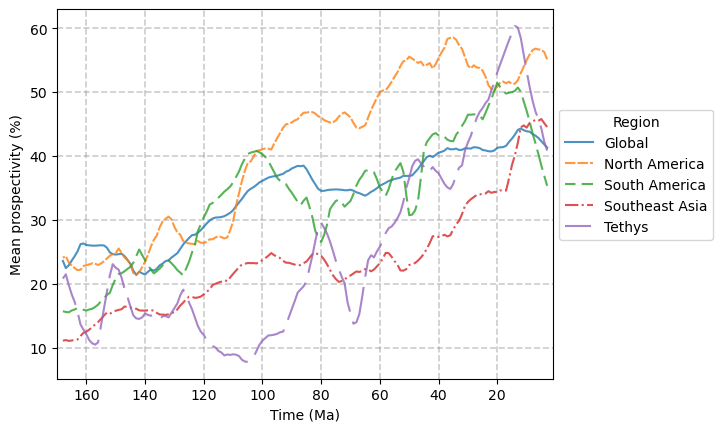

In [10]:
output_basename = os.path.join(figures_dir, "mean_prospectivity")

q = "mean"

linestyles = cycle((
    "solid",
    (0, (5, 1)),
    (5, (10, 3)),
    "dashdot",
    (7.5, (20, 5)),
))
fig, ax = plt.subplots()
for region, linestyle in zip(regions, linestyles):
    s = quantiles[region][q]
    if window_size is not None:
        s = s.rolling(window_size, center=True).mean()
    ax.plot(
        s.index,
        s * 100,
        linestyle=linestyle,
        linewidth=1.5,
        alpha=0.8,
        label=region,
    )
fig.legend(
    title="Region",
    loc=(0, 0),
    bbox_to_anchor=(0.91, 0.4),
)
ax.set_xlim(s.index.max(), s.index.min())
ax.grid(
    linestyle="dashed",
    alpha=0.4,
    color="grey",
    linewidth=1.2,
)
ax.set_xlabel("Time (Ma)")
ax.set_ylabel("Mean prospectivity (%)")

for ext in ("pdf", "png"):
    fig.savefig(
        output_basename + f".{ext}",
        dpi=350,
        bbox_inches="tight",
    )

With preservation:

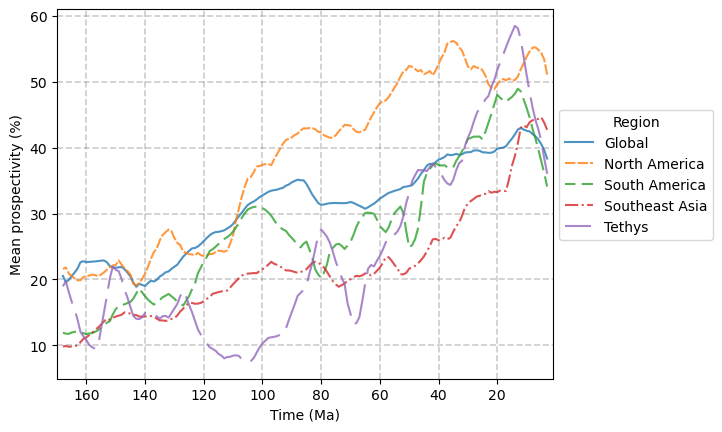

In [11]:
output_basename = os.path.join(figures_dir, "mean_prospectivity_preservation")

fig, ax = plt.subplots()
for region, linestyle in zip(regions, linestyles):
    s = quantiles_preservation[region][q]
    if window_size is not None:
        s = s.rolling(window_size, center=True).mean()
    ax.plot(
        s.index,
        s * 100,
        linestyle=linestyle,
        linewidth=1.5,
        alpha=0.8,
        label=region,
    )
fig.legend(
    title="Region",
    loc=(0, 0),
    bbox_to_anchor=(0.91, 0.4),
)
ax.set_xlim(s.index.max(), s.index.min())
ax.grid(
    linestyle="dashed",
    alpha=0.4,
    color="grey",
    linewidth=1.2,
)
ax.set_xlabel("Time (Ma)")
ax.set_ylabel("Mean prospectivity (%)")

for ext in ("pdf", "png"):
    fig.savefig(
        output_basename + f".{ext}",
        dpi=350,
        bbox_inches="tight",
    )

### Prospective area through time

Total area over a given prospectivity threshold.

#### Line plot

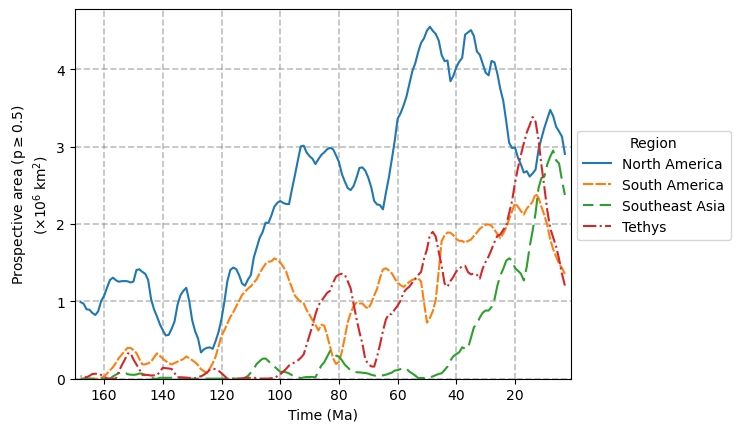

In [12]:
q = qs[5]
output_basename = os.path.join(
    figures_dir,
    f"prospective_area_p_{q:0.1f}.png",
)

linestyles = cycle((
    "solid",
    (0, (5, 1)),
    (5, (10, 3)),
    "dashdot",
    (7.5, (20, 5)),
))
fig, ax = plt.subplots()
for region, linestyle in zip(regions[1:], linestyles):
    s = quantiles_areas[region][q]
    if window_size is not None:
        s = s.rolling(window_size, center=True).mean()
    ax.plot(
        s.index,
        s * 1.0e-6,
        linestyle=linestyle,
        label=region,
    )
fig.legend(
    title="Region",
    loc=(0, 0),
    bbox_to_anchor=(0.91, 0.4),
)
ax.set_xlim(s.index.max(), s.index.min())
ax.set_ylim(0)
ax.grid(
    linestyle="dashed",
    alpha=0.5,
    color="grey",
    linewidth=1.2,
)
ax.set_xlabel("Time (Ma)")
ax.set_ylabel(
    r"Prospective area ($\mathrm{p} \geq "
    + f"{q:0.1f}"
    + r"$)"
    + "\n"
    r"($\mathrm{\times 10^6\;km^2}$)"
)

for ext in ("pdf", "png"):
    fig.savefig(
        output_basename + f".{ext}",
        dpi=350,
        bbox_inches="tight",
    )

With preservation:

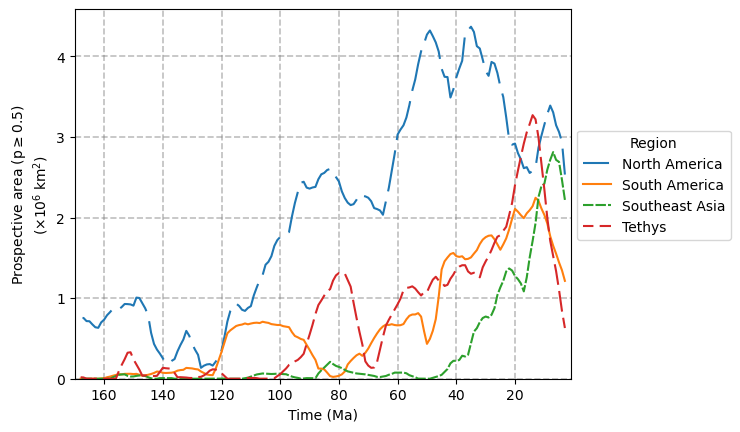

In [13]:
output_filename = os.path.join(
    figures_dir,
    f"prospective_area_preservation_p_{q:0.1f}.png",
)

fig, ax = plt.subplots()
for region, linestyle in zip(regions[1:], linestyles):
    s = quantiles_areas_preservation[region][q]
    if window_size is not None:
        s = s.rolling(window_size, center=True).mean()
    ax.plot(
        s.index,
        s * 1.0e-6,
        linestyle=linestyle,
        label=region,
    )
fig.legend(
    title="Region",
    loc=(0, 0),
    bbox_to_anchor=(0.91, 0.4),
)
ax.set_xlim(s.index.max(), s.index.min())
ax.set_ylim(0)
ax.grid(
    linestyle="dashed",
    alpha=0.5,
    color="grey",
    linewidth=1.2,
)
ax.set_xlabel("Time (Ma)")
ax.set_ylabel(
    r"Prospective area ($\mathrm{p} \geq "
    + f"{q:0.1f}"
    + r"$)"
    + "\n"
    r"($\mathrm{\times 10^6\;km^2}$)"
)

fig.savefig(output_filename, dpi=350, bbox_inches="tight")

#### Horizontal stackplot

Also plot a histogram of known deposits, to highlight any discrepancies with the model.

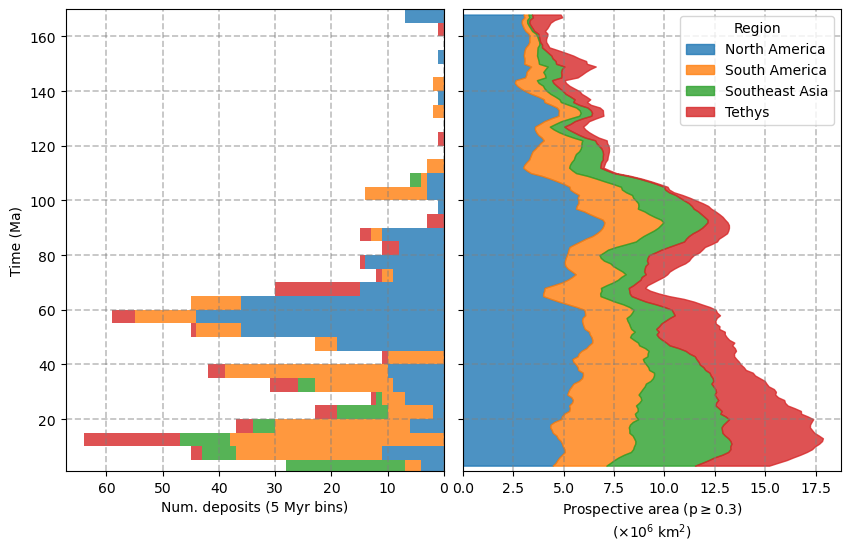

In [14]:
q = qs[3]
alpha = 0.8
if window_size is None or window_size < 5:
    bin_size = 5
else:
    bin_size = window_size  # Myr

output_filename = os.path.join(
    figures_dir,
    f"prospective_areas_stacked_p_{q:0.1f}.png",
)

def stackploth(ax, y, *args, **kwargs):
    y = np.ravel(y)
    ny = np.size(y)
    args = [np.array(i) for i in args]
    if len(args) == 1 and args[0].shape[1] == ny:
        args = list(args[0])
    elif len(args) == 0:
        raise ValueError(f"Invalid x: {args}")

    tot = np.zeros(ny)
    labels = cycle(kwargs.pop("labels", [None]))
    if "colors" in kwargs and kwargs["colors"] is not None:
        colors = cycle(kwargs.pop("colors"))
        colors_defined = True
    else:
        colors = cycle([None])
        colors_defined = False
    hatch = cycle(kwargs.pop("hatch", [None]))

    out = []
    for x, label, color, h in zip(
        args,
        labels,
        colors,
        hatch,
    ):
        if colors_defined:
            l = ax.fill_betweenx(
                y,
                x1=tot,
                x2=tot + x,
                label=label,
                color=color,
                hatch=h,
                **kwargs
            )
        else:
            l = ax.fill_betweenx(
                y,
                x1=tot,
                x2=tot + x,
                label=label,
                hatch=h,
                **kwargs
            )
        out.append(l)
        tot += x
    return out


fig, (ax1, ax2) = plt.subplots(
    1, 2,
    sharey=True,
    figsize=(10, 6),
    gridspec_kw=dict(
        wspace=0.05,
    )
)

# Deposits histogram
gb = deposits.groupby("region")
groups = [
    gb.get_group(region)["age (Ma)"]
    for region in regions[1:]
]
bins = np.arange(
    0.0,
    quantiles_areas[regions[1]][q].index.max() + bin_size,
    bin_size,
)
hist = ax1.hist(
    groups,
    bins=bins,
    orientation="horizontal",
    stacked=True,
    alpha=alpha,
)
colors = [
    i.patches[0].get_facecolor()
    for i in hist[2]
]
ax1.set_xlabel(f"Num. deposits ({bin_size:0.0f} Myr bins)")
ax1.set_ylabel("Time (Ma)")
ax1.set_xlim(*(ax1.get_xlim()[::-1]))

# Stacked area plot
ys = [
    quantiles_areas[region][q].rolling(window_size, center=True).mean() * 1.0e-6
    for region in regions[1:]
]
xs = ys[0].index
stackploth(
    ax2,
    xs,
    ys,
    labels=regions[1:],
    alpha=alpha,
    colors=colors,
)
ax2.set_xlim(0)
ax2.set_xlabel(
    r"Prospective area ($\mathrm{p} \geq "
    + f"{q:0.1f}"
    + r"$)"
    + "\n"
    r"($\mathrm{\times 10^6\;km^2}$)"
)

for ax in (ax1, ax2):
    ax.set_ylim(s.index.min(), s.index.max())
    ax.grid(
        linestyle="dashed",
        alpha=0.5,
        color="grey",
        linewidth=1.2,
    )
ax2.legend(title="Region")

# fig.suptitle("Regional models", y=0.95, fontsize=16)

fig.savefig(output_filename, dpi=350, bbox_inches="tight")

With preservation:

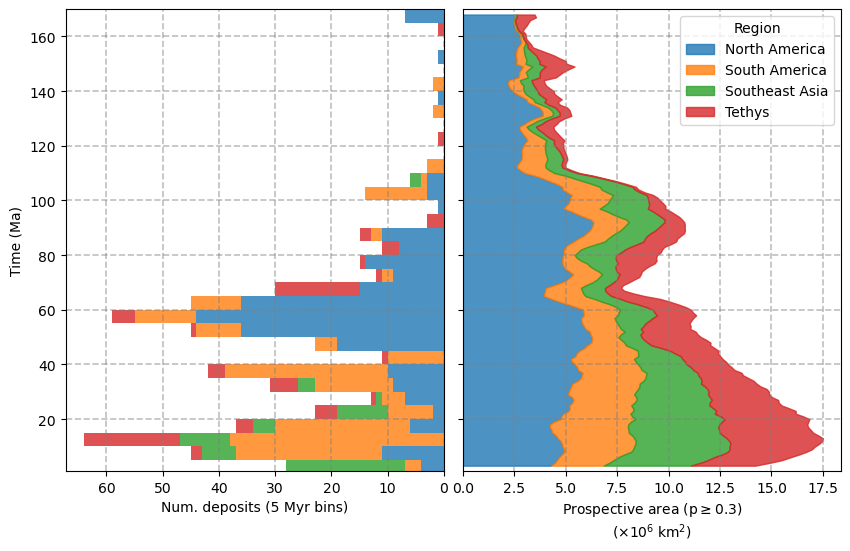

In [15]:
output_basename = os.path.join(
    figures_dir,
    f"prospective_areas_preservation_stacked_p_{q:0.1f}",
)

fig, (ax1, ax2) = plt.subplots(
    1, 2,
    sharey=True,
    figsize=(10, 6),
    gridspec_kw=dict(
        wspace=0.05,
    )
)

# Deposits histogram
gb = deposits.groupby("region")
groups = [
    gb.get_group(region)["age (Ma)"]
    for region in regions[1:]
]
bins = np.arange(
    0.0,
    quantiles_areas_preservation[regions[1]][q].index.max() + bin_size,
    bin_size,
)
hist = ax1.hist(
    groups,
    bins=bins,
    orientation="horizontal",
    stacked=True,
    alpha=alpha,
)
colors = [
    i.patches[0].get_facecolor()
    for i in hist[2]
]
ax1.set_xlabel(f"Num. deposits ({bin_size:0.0f} Myr bins)")
ax1.set_ylabel("Time (Ma)")
ax1.set_xlim(*(ax1.get_xlim()[::-1]))

# Stacked area plot
ys = [
    quantiles_areas_preservation[region][q].rolling(window_size, center=True).mean() * 1.0e-6
    for region in regions[1:]
]
xs = ys[0].index
stackploth(
    ax2,
    xs,
    ys,
    labels=regions[1:],
    alpha=alpha,
    colors=colors,
)
ax2.set_xlim(0)
ax2.set_xlabel(
    r"Prospective area ($\mathrm{p} \geq "
    + f"{q:0.1f}"
    + r"$)"
    + "\n"
    r"($\mathrm{\times 10^6\;km^2}$)"
)

for ax in (ax1, ax2):
    ax.set_ylim(s.index.min(), s.index.max())
    ax.grid(
        linestyle="dashed",
        alpha=0.5,
        color="grey",
        linewidth=1.2,
    )
ax2.legend(title="Region")

for ext in ("pdf", "png"):
    fig.savefig(
        output_basename + f".{ext}",
        dpi=350,
        bbox_inches="tight",
    )

### Prospective area through time (global model)

As above, using only the global model this time.

#### Horizontal stackplot

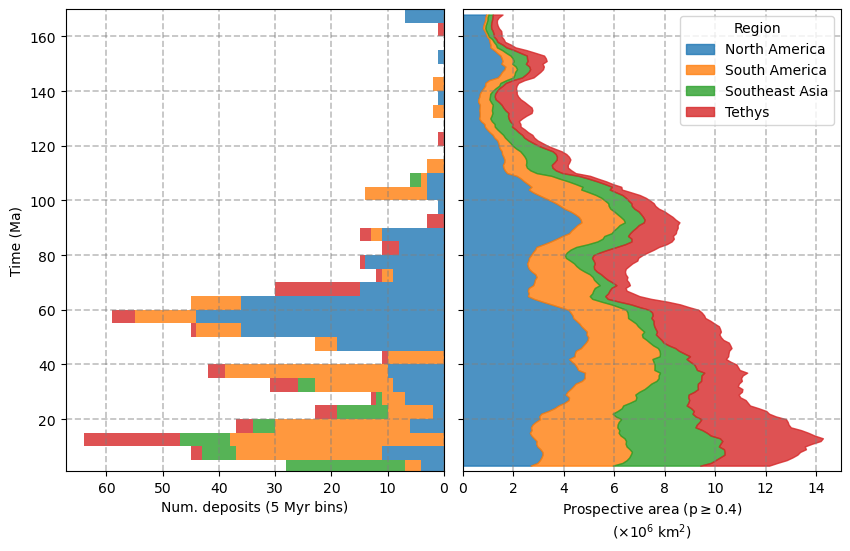

In [16]:
q = qs[4]
alpha = 0.8

output_filename = os.path.join(
    figures_dir,
    f"prospective_areas_stacked_global_model_p_{q:0.1f}.png",
)

fig, (ax1, ax2) = plt.subplots(
    1, 2,
    sharey=True,
    figsize=(10, 6),
    gridspec_kw=dict(
        wspace=0.05,
    )
)

# Deposits histogram
gb = deposits.groupby("region")
groups = [
    gb.get_group(region)["age (Ma)"]
    for region in regions[1:]
]
bins = np.arange(
    0.0,
    quantiles_areas_global[regions[1]][q].index.max() + bin_size,
    bin_size,
)
hist = ax1.hist(
    groups,
    bins=bins,
    orientation="horizontal",
    stacked=True,
    alpha=alpha,
)
colors = [
    i.patches[0].get_facecolor()
    for i in hist[2]
]
ax1.set_xlabel(f"Num. deposits ({bin_size:0.0f} Myr bins)")
ax1.set_ylabel("Time (Ma)")
ax1.set_xlim(*(ax1.get_xlim()[::-1]))

# Stacked area plot
ys = [
    quantiles_areas_global[region][q].rolling(window_size, center=True).mean() * 1.0e-6
    for region in regions[1:]
]
xs = ys[0].index
stackploth(
    ax2,
    xs,
    ys,
    labels=regions[1:],
    alpha=alpha,
    colors=colors,
)
ax2.set_xlim(0)
ax2.set_xlabel(
    r"Prospective area ($\mathrm{p} \geq "
    + f"{q:0.1f}"
    + r"$)"
    + "\n"
    r"($\mathrm{\times 10^6\;km^2}$)"
)

for ax in (ax1, ax2):
    ax.set_ylim(s.index.min(), s.index.max())
    ax.grid(
        linestyle="dashed",
        alpha=0.5,
        color="grey",
        linewidth=1.2,
    )
ax2.legend(title="Region")

# fig.suptitle("Global model", y=0.95, fontsize=16)

fig.savefig(output_filename, dpi=350, bbox_inches="tight")

### Erosion through time

Plots showing erosion rates in arcs through time and the cumulative erosion to the present day.

#### Erosion rate

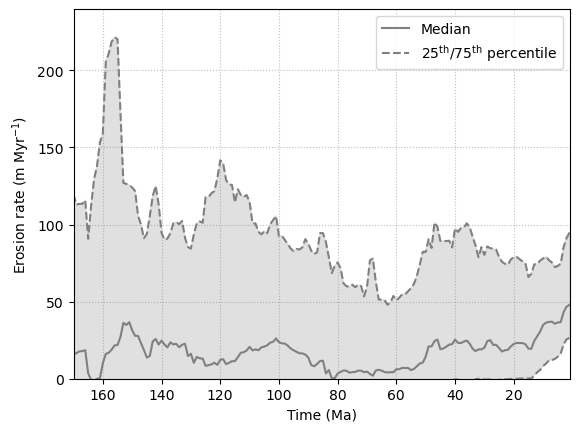

In [17]:
erosion_rate_image_basename = os.path.join(
    figures_dir,
    "erosion_rate",
)

fig, ax = plt.subplots()
for q in qs_erosion:
    dashed = ax.plot(
        times,
        quantiles_erosion_gradient[q],
        linestyle="dashed",
        color="grey",
        zorder=1,
    )[0]
solid = ax.plot(
    times,
    quantiles_erosion_gradient[0.5],
    linestyle="solid",
    color="grey",
    zorder=1,
)[0]
ax.fill_between(
    times,
    quantiles_erosion_gradient[qs_erosion[0]],
    quantiles_erosion_gradient[qs_erosion[1]],
    color="lightgrey",
    alpha=0.7,
    zorder=0,
)
ax.set_xlim(max(times), min(times))
ax.set_ylim(0.0)
ax.set_xlabel("Time (Ma)")
ax.set_ylabel(r"Erosion rate ($\mathrm{m\;{Myr}^{-1}}$)")
ax.grid(linestyle="dotted", color="grey", alpha=0.5)

ax.legend(
    (solid, dashed),
    (
        "Median",
        (
            r"$\mathrm{"
            + f"{qs_erosion[0] * 100:0.0f}"
            + r"^{th}}$/$\mathrm{"
            + f"{qs_erosion[1] * 100:0.0f}"
            + r"^{th}}$ percentile"
        ),
    ),
)
for ext in ("pdf", "png"):
    fig.savefig(
        erosion_rate_image_basename + f".{ext}",
        dpi=350,
        bbox_inches="tight",
    )

#### Cumulative erosion

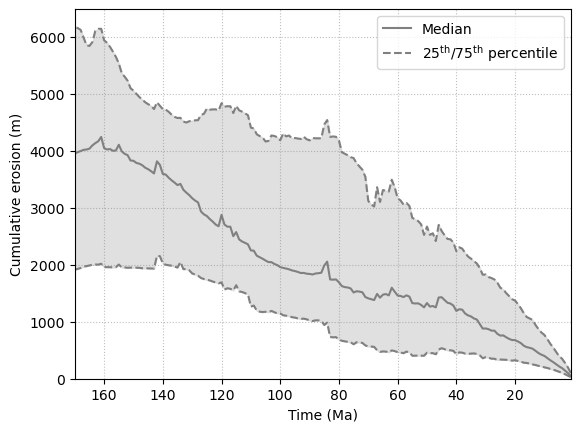

In [18]:
erosion_image_basename = os.path.join(
    figures_dir,
    "erosion_cumulative",
)

fig, ax = plt.subplots()
for q in qs_erosion:
    dashed = ax.plot(
        times,
        quantiles_erosion[q],
        linestyle="dashed",
        color="grey",
        zorder=1,
    )[0]
solid = ax.plot(
    times,
    quantiles_erosion[0.5],
    linestyle="solid",
    color="grey",
    zorder=1,
)[0]
ax.fill_between(
    times,
    quantiles_erosion[qs_erosion[0]],
    quantiles_erosion[qs_erosion[1]],
    color="lightgrey",
    alpha=0.7,
    zorder=0,
)
ax.set_xlim(max(times), min(times))
ax.set_ylim(0.0)
ax.set_xlabel("Time (Ma)")
ax.set_ylabel("Cumulative erosion (m)")
ax.grid(linestyle="dotted", color="grey", alpha=0.5)

ax.legend(
    (solid, dashed),
    (
        "Median",
        (
            r"$\mathrm{"
            + f"{qs_erosion[0] * 100:0.0f}"
            + r"^{th}}$/$\mathrm{"
            + f"{qs_erosion[1] * 100:0.0f}"
            + r"^{th}}$ percentile"
        ),
    ),
)
for ext in ("pdf", "png"):
    fig.savefig(
        erosion_image_basename + f".{ext}",
        dpi=350,
        bbox_inches="tight",
    )